### Figure 3. SparseStack: Acceleration over Gaussian. 
Runtime to form the sketch $\mathbf{A}\mathbf{\Omega} \in \mathbb{R}^{n\times k}$
of a dense input matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$
when the test matrix $\mathbf{\Omega} \in \mathbb{R}^{n \times k}$
is either Gaussian (dashed) or SparseStack (solid)
with row sparsity $\zeta$.

The ambient dimension is $n = 50{,}000$;
the panels compare embedding dimensions $k = 500, 2500, 25{,}000$;
and the series track the median over 10 trials.

Decreasing the sparsity $\zeta$ is critical to
achieving the greatest speed.  
At the recommended sparsity $\zeta = 4$, SparseStack
is empirically OSI ,
and the acceleration over the Gaussian baseline
ranges from $7\times$ to $88\times$.

---

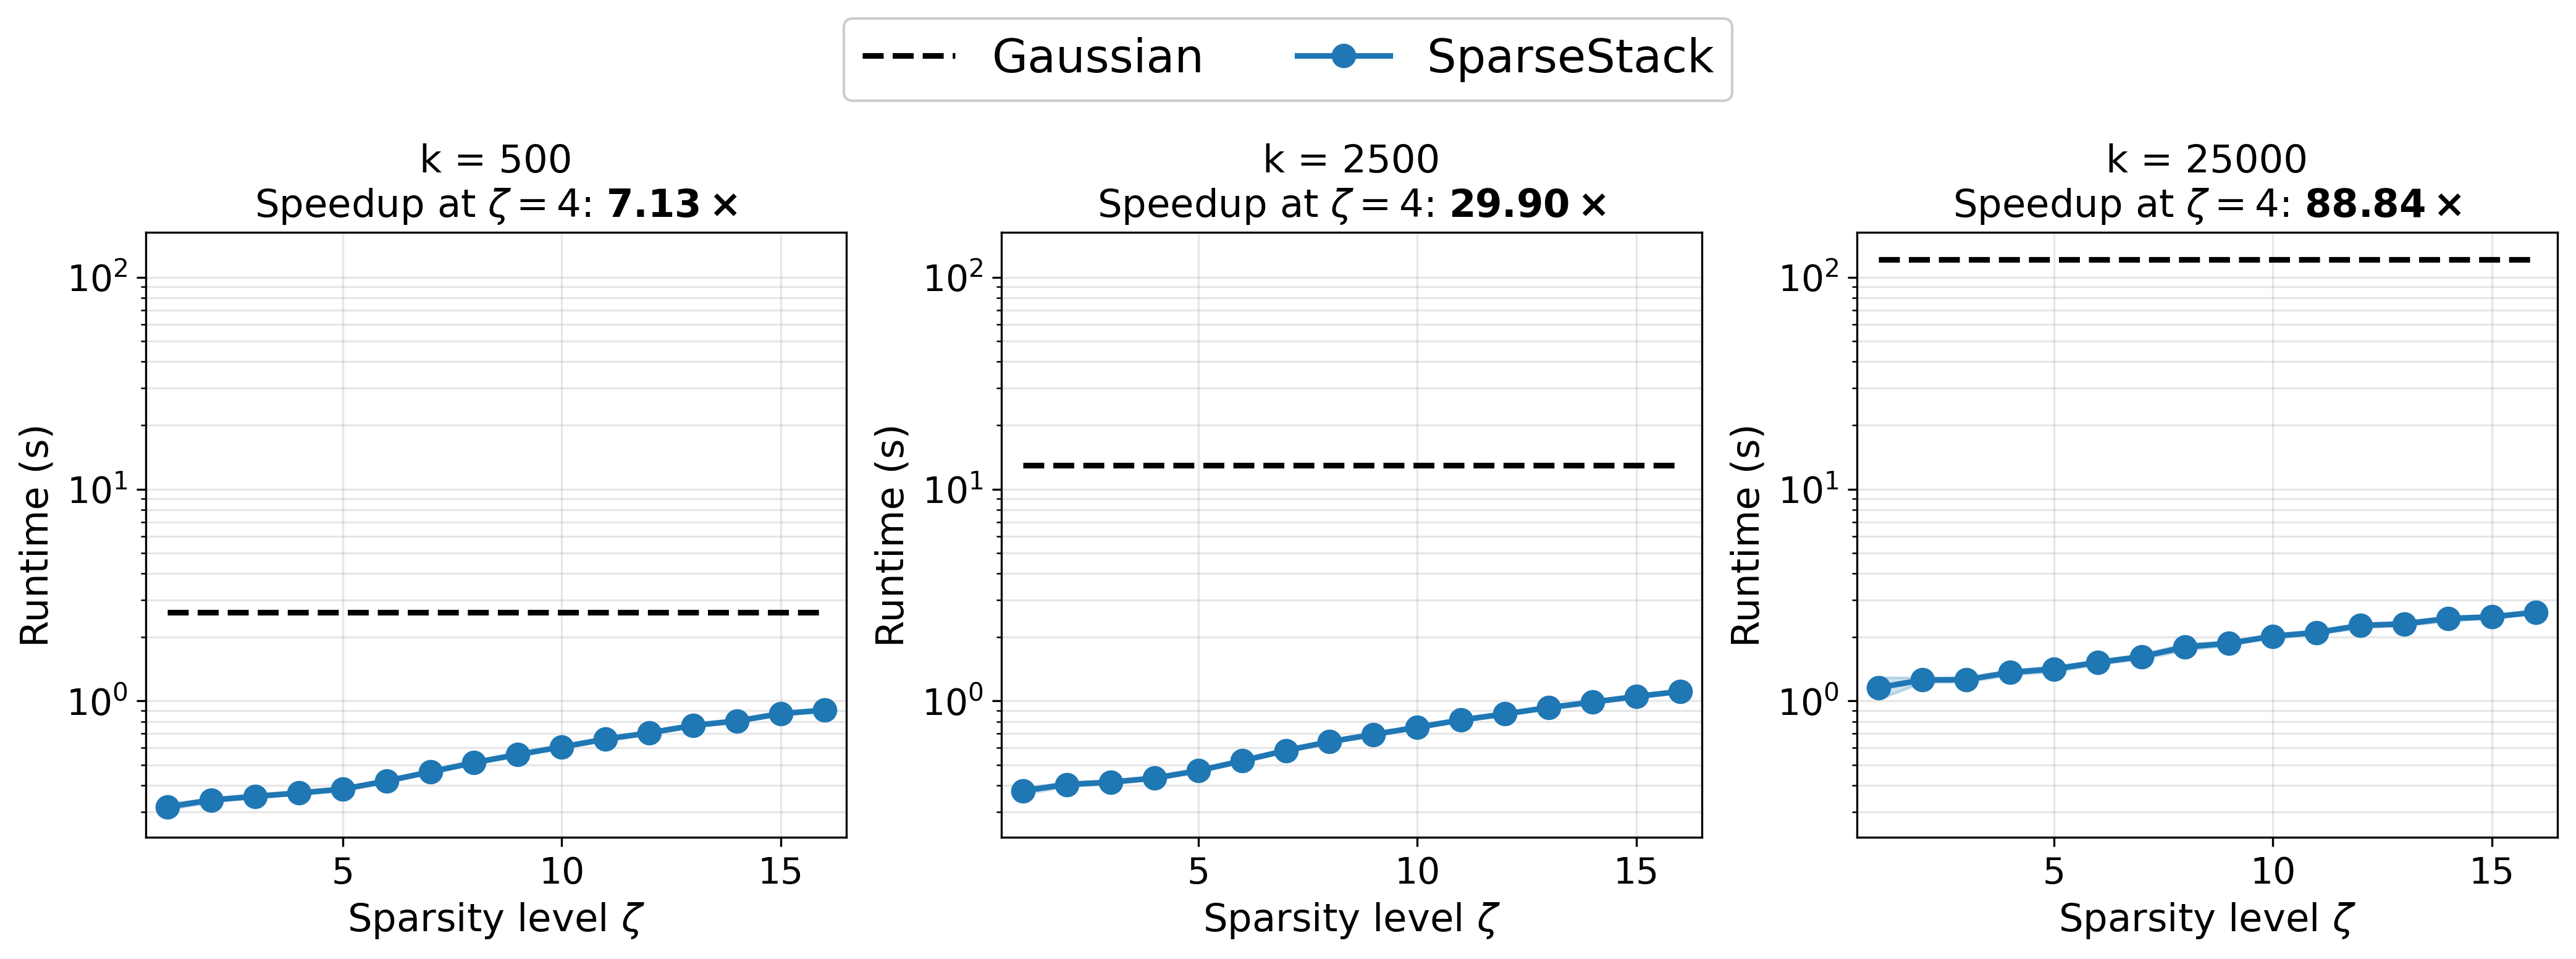

In [8]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FuncFormatter
from matplotlib.ticker import MultipleLocator, FuncFormatter

MAT_PATH = "data/Sparse_sign_timing_multiK.mat"
mat = scipy.io.loadmat(MAT_PATH)

raw = mat["raw_data"]
times_sparse = raw["times_sparse"][0, 0]   # (num_runs, numZeta, num_k)
times_gauss  = raw["times_gauss"][0, 0]    # (num_runs, numZeta, num_k)
zeta_vals    = raw["zeta_vals"][0, 0].ravel().astype(int)
k_values     = raw["k_values"][0, 0].ravel().astype(int)
d            = int(np.array(raw["d"][0, 0]).ravel()[0])

num_runs, numZeta, num_k = times_sparse.shape
ddof = 1 if num_runs > 1 else 0
mean_ss = np.mean(times_sparse, axis=0)
std_ss  = np.std(times_sparse, axis=0, ddof=ddof)
mean_g  = np.mean(times_gauss, axis=0)

marker_edge_width  = 1.5
marker_size_sparse = 8
line_width         = 2.2
alpha_fill         = 0.22
font_label         = 15   # larger
font_tick          = 14   # larger
font_legend        = 18   # larger

zeta_target = 4
_has_exact  = np.any(zeta_vals == zeta_target)
if _has_exact:
    _idx_z = int(np.where(zeta_vals == zeta_target)[0][0])
else:
    _idx_z = int(np.argmin(np.abs(zeta_vals - zeta_target)))

fig, axes = plt.subplots(1, num_k, figsize=(14, 5), sharey=True, dpi=300)
if num_k == 1:
    axes = [axes]

_locator   = MultipleLocator(5)  
_formatter = FuncFormatter(lambda x, pos: f"{int(x)}")

for ik in range(num_k):
    ax = axes[ik]

    mu = mean_ss[:, ik]
    sd = std_ss[:, ik]
    lower = np.clip(mu - sd, 1e-16, None)
    upper = mu + sd

    ax.fill_between(zeta_vals, lower, upper, alpha=alpha_fill, color='C0')
    ss_line = ax.plot(
        zeta_vals, mu, '-o',
        color='C0',
        markerfacecolor='C0',
        markeredgecolor='C0',
        markeredgewidth=marker_edge_width,
        markersize=marker_size_sparse,
        linewidth=line_width,
        label='SparseStack'
    )[0]

    g_line = ax.plot(
        zeta_vals, mean_g[:, ik], '--',
        color='black',
        linewidth=line_width,
        label='Gaussian'
    )[0]

    with np.errstate(divide='ignore', invalid='ignore'):
        speedup_at_zeta = mean_g[_idx_z, ik] / mu[_idx_z]
    speedup_tex = r'$\mathbf{' + f'{speedup_at_zeta:.2f}' + r'\times}$'

    if _has_exact:
        title = (
            f'k = {int(k_values[ik])}\n'
            rf'Speedup at $\zeta={zeta_target}$: ' + speedup_tex
        )
    else:
        used = int(zeta_vals[_idx_z])
        title = (
            f'd = {d}, k = {int(k_values[ik])}\n'
            rf'Speedup at $\zeta={zeta_target}$ (nearest $\zeta={used}$): ' + speedup_tex
        )
    ax.set_title(title, fontsize=font_label)

    ax.set_xscale('linear')
    if zeta_vals.size >= 2:
        pad = 0.5 * np.min(np.diff(np.sort(zeta_vals)))
    else:
        pad = 0.5
    ax.set_xlim(zeta_vals.min() - pad, zeta_vals.max() + pad)

    ax.xaxis.set_major_locator(_locator)
    ax.xaxis.set_major_formatter(_formatter)

    ax.set_yscale('log')
    ax.set_xlabel(r'Sparsity level $\zeta$', fontsize=font_label)
    ax.set_ylabel('Runtime (s)', fontsize=font_label)
    ax.tick_params(axis='both', labelsize=font_tick)
    ax.tick_params(axis='y', which='both', labelleft=True)
    ax.grid(True, which='both', alpha=0.3)

# === Legend (Gaussian first, then SparseStack) ===
handles, labels = axes[0].get_legend_handles_labels()
order = [labels.index("Gaussian"), labels.index("SparseStack")]
fig.legend(
    [handles[i] for i in order], [labels[i] for i in order],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=2,
    fancybox=True,
    framealpha=1.0,
    fontsize=font_legend
)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("fig3.png", dpi=300, bbox_inches="tight")
plt.show()